In [3]:
! pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [4]:
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastai.vision.widgets import ImageClassifierCleaner

In [5]:
from pathlib import Path
import os,time,datetime as dt
from PIL import Image
# from dotenv import load_dotenv
from IPython.display import display
from urllib.parse import urlsplit
import requests

In [6]:
UNSPLASH_KEY = os.getenv('ACCESS_KEY')

In [7]:
def unsplash_search(query: str, per_page: int = 5, page: int = 1):
    ## Return a list of URLs for images of the query
    endpoint = 'https://api.unsplash.com/search/photos'
    headers = { 
        "Authorization": f"Client-ID {UNSPLASH_KEY}",
        "Accept-Version": "v1",
    }
    params = {
        "query" : query,
        "page" : page,
        "per_page" : per_page,
    }
    try:
        response = requests.get(endpoint, headers= headers, params= params, timeout= 15)
        if response.status_code == 429:
            reset = 3600 - dt.datetime.now().minute * 60
            print(f"Rate limit exceeded. Resetting in {reset} seconds.")
            time.sleep(reset)
            return unsplash_search(query, per_page, page)
        response.raise_for_status()

        print(f"Remaining this hour: {response.headers['x-ratelimit-remaining']}")

        results = response.json().get('results',[])
        return[
            {
                'id': photo['id'],
                'self': photo['links']['self'],
                'html': photo['links']['html'],
                'url': photo['urls']['full'],
                'credit': f"{photo['user']['name']} on Unsplash",

            }
            for photo in results
        ]
    except Exception as e:
        print(f"Error searching for {query}: {e}")
        return []

In [8]:
unsplash_search('dog', 1)

Remaining this hour: 49


[{'id': 'yihlaRCCvd4',
  'self': 'https://api.unsplash.com/photos/dog-running-on-beach-during-daytime-yihlaRCCvd4',
  'html': 'https://unsplash.com/photos/dog-running-on-beach-during-daytime-yihlaRCCvd4',
  'url': 'https://images.unsplash.com/photo-1530281700549-e82e7bf110d6?crop=entropy&cs=srgb&fm=jpg&ixid=M3w3NTY5NjZ8MHwxfHNlYXJjaHwxfHxkb2d8ZW58MHx8fHwxNzQ5MTgyMjU5fDA&ixlib=rb-4.1.0&q=85',
  'credit': 'Oscar Sutton on Unsplash'}]

In [9]:
def download_image(url: str, dest_folder: Path | str = "images", timeout: int = 15):
    dest_folder = Path(dest_folder)
    dest_folder.mkdir(parents=True, exist_ok=True)
    
    # Derive a filename from the URL, fall back to .jpg if no extension
    basename = Path(urlsplit(url).path).name
    if "." not in basename: 
        basename += ".jpg"
    dest_path = dest_folder / basename

    try: 
        response = requests.get(url,stream=True, timeout=timeout,headers= {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'})
        response.raise_for_status()

        with open(dest_path, "wb") as f:
            for chunk in response.iter_content(8192):
                f.write(chunk)
        return dest_path
    except requests.exceptions.RequestException as e:
        print(f"[download_image] Failed: {e}")
        return None

In [10]:
def show_image(path: Path | str, size: tuple[int,int] = None):
    if path and Path(path).exists(): # check if the path exists
        img = Image.open(path)

        # Resize the image
        if size:
            img = img.resize(size,Image.Resampling.LANCZOS)

        display(img)
    else:
        print(f"[show_image] No image found in: {path}")

Remaining this hour: 48
Downloading: https://images.unsplash.com/photo-1599948058230-78896e742f7e?crop=entropy&cs=srgb&fm=jpg&ixid=M3w3NTY5NjZ8MHwxfHNlYXJjaHwxfHxncml6emx5JTIwYmVhcnxlbnwwfHx8fDE3NDkxODIyNjB8MA&ixlib=rb-4.1.0&q=85


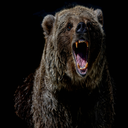

In [11]:
# 1️⃣ Search Google Images
results = unsplash_search("grizzly bear", per_page=1)

# 2️⃣ Grab the first image URL
if results:
    img_url = results[0]["url"]
    print(f"Downloading: {img_url}")

    # 3️⃣ Download it
    saved_path = download_image(img_url)

    # 4️⃣ Display it inline
    show_image(saved_path, size=(128,128))
else:
    print("No image results returned.")

In [12]:
def fetch_unsplash_image(query: str, total_results: int = 30, per_page: int = 10):
    all_results = []
    page = 1

    while len(all_results) < total_results:
        remaining = total_results - len(all_results)
        current_page_results = min(per_page, remaining)

        batch = unsplash_search(query, per_page=current_page_results, page=page)
        if not batch:
            print(f"No more results found for {query}")
            break
        all_results.extend(batch)
        page += 1

    return all_results
        


In [13]:
def bears_dataset():
    bear_types = ['black bear','grizzly bear','teddy bear']
    for bear_type in bear_types:
        results = fetch_unsplash_image(f"{bear_type}", total_results=100,per_page=30)
        dest = Path('bears') / bear_type
        dest.mkdir(parents=True, exist_ok=True)

        for i, result in enumerate(results):
            try:
                url = result['url']
                img_path = download_image(url, dest_folder=dest)
                print(f"[{bear_type}] Downloaded {i+1}: {img_path.name}")
            except Exception as e:
                print(f"Skipped an image due to error: {e}")
    return dest

In [14]:
path = bears_dataset()

Remaining this hour: 47
Remaining this hour: 46
Remaining this hour: 45
Remaining this hour: 44
[black bear] Downloaded 1: photo-1597117903702-fb2788ddf816.jpg
[black bear] Downloaded 2: photo-1597117903705-18322e8f997f.jpg
[black bear] Downloaded 3: photo-1596635633339-1fe572f244e2.jpg
[black bear] Downloaded 4: photo-1588167056840-13caf6e4562a.jpg
[black bear] Downloaded 5: photo-1563036203-8ecb9d80bea7.jpg
[black bear] Downloaded 6: photo-1588736474574-df2a4ac3bb5a.jpg
[black bear] Downloaded 7: photo-1592186534355-ae2784d4c3da.jpg
[black bear] Downloaded 8: photo-1557773958-8f4e7bd5bf60.jpg
[black bear] Downloaded 9: photo-1603204390039-7488a29bc389.jpg
[black bear] Downloaded 10: photo-1563301141-0b0e316cb602.jpg
[black bear] Downloaded 11: photo-1541560584704-f2767960951a.jpg
[black bear] Downloaded 12: photo-1611504262166-fa362a217f5c.jpg
[black bear] Downloaded 13: photo-1572118545839-fe487faa34cb.jpg
[black bear] Downloaded 14: photo-1627851039170-6fa7f212bc0d.jpg
[black bear]

In [15]:
fns = get_image_files(Path('bears'))
fns

(#269) [Path('bears/black bear/photo-1495218038559-698735541a8d.jpg'),Path('bears/black bear/photo-1496297679486-1a1607669129.jpg'),Path('bears/black bear/photo-1497220736297-bc6b16c28bfd.jpg'),Path('bears/black bear/photo-1500064171035-d88a47d65074.jpg'),Path('bears/black bear/photo-1506866858181-6151d9afdf27.jpg'),Path('bears/black bear/photo-1508689863005-6dccd8b40ad8.jpg'),Path('bears/black bear/photo-1515693152446-d119aafd4af4.jpg'),Path('bears/black bear/photo-1522506844266-a84bf0326f15.jpg'),Path('bears/black bear/photo-1534423292-00e1ff92db6a.jpg'),Path('bears/black bear/photo-1534486920529-ec947a6bfa58.jpg'),Path('bears/black bear/photo-1541560584704-f2767960951a.jpg'),Path('bears/black bear/photo-1541874658046-7e988e4deff3.jpg'),Path('bears/black bear/photo-1543853796-a9333690f002.jpg'),Path('bears/black bear/photo-1551800458-0d3312e80b3b.jpg'),Path('bears/black bear/photo-1552945618-202847a01f05.jpg'),Path('bears/black bear/photo-1554499342-42afe3db75a9.jpg'),Path('bears/bla

In [16]:
failed = verify_images(fns)
failed

(#0) []

# Creating and testing our DataBlock

In [17]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,   
    item_tfms=Resize(128)
)

In [18]:
dls = bears.dataloaders(Path('bears'))

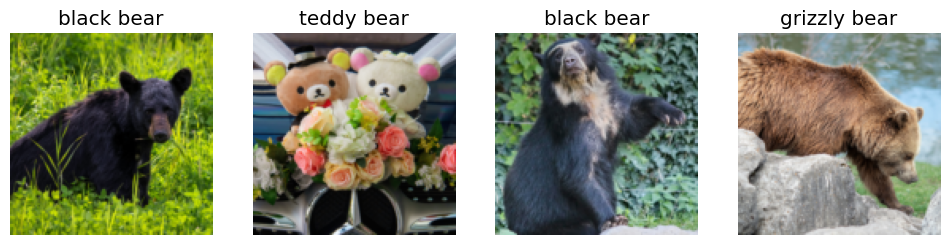

In [19]:
dls.valid.show_batch(max_n=4, nrows=1)


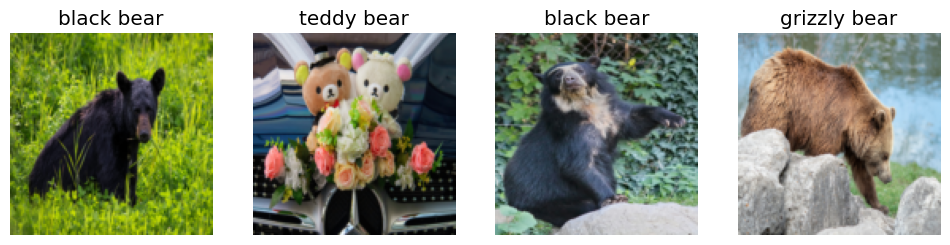

In [20]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(Path('bears'))
dls.valid.show_batch(max_n=4, nrows=1)

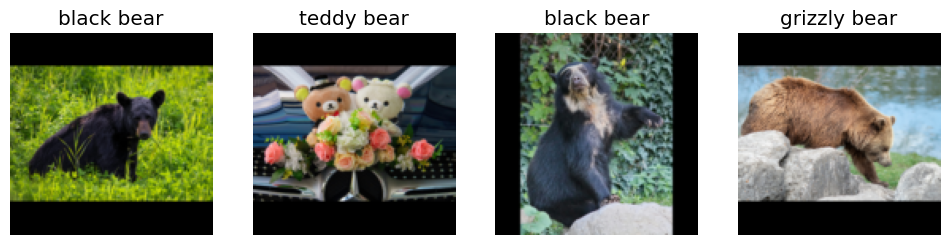

In [21]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(Path('bears'))
dls.valid.show_batch(max_n=4, nrows=1)

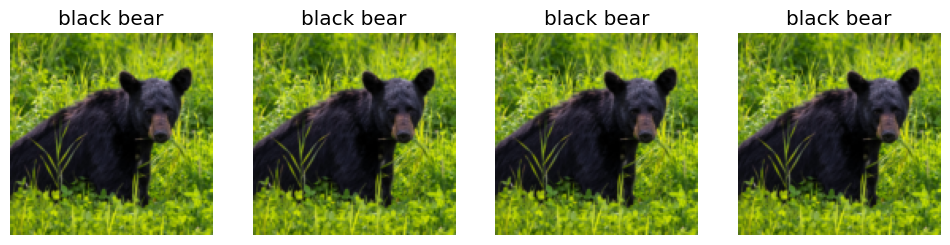

In [22]:
bears = bears.new(item_tfms=Resize(128, RandomResizedCrop(128, min_scale=0.3)))
dls = bears.dataloaders(Path('bears'))
dls.valid.show_batch(max_n=4, nrows=1, unique=True)


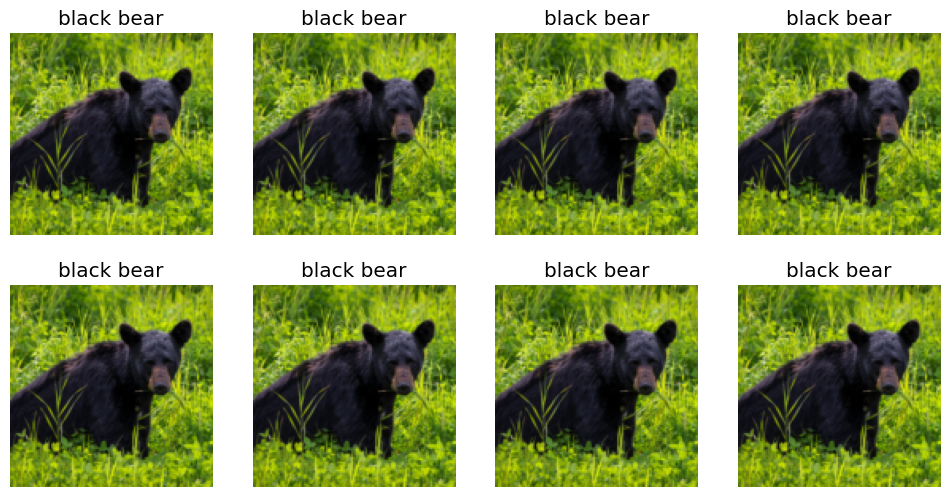

In [23]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(Path('bears'))
dls.valid.show_batch(max_n=8, nrows=2, unique=True)


In [24]:
bears = bears.new(item_tfms=Resize(128, RandomResizedCrop(224, min_scale=0.5)), batch_tfms=aug_transforms())
dls = bears.dataloaders(Path('bears'))

In [25]:
learn = vision_learner(dls,resnet18,metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.885926,1.213521,0.433962,01:48


epoch,train_loss,valid_loss,error_rate,time
0,1.189456,0.755741,0.245283,01:51
1,0.946738,0.538200,0.169811,01:43
2,0.787258,0.508924,0.150943,01:38
3,0.725952,0.488354,0.132075,01:38


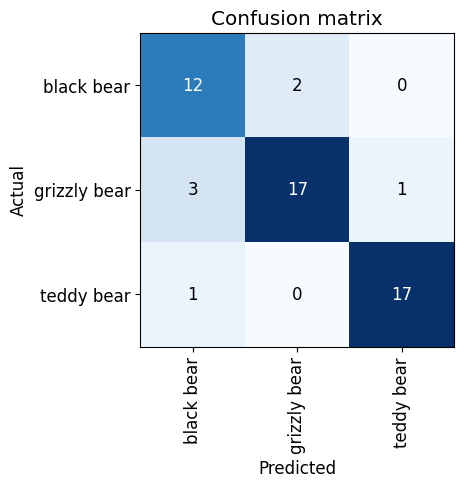

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

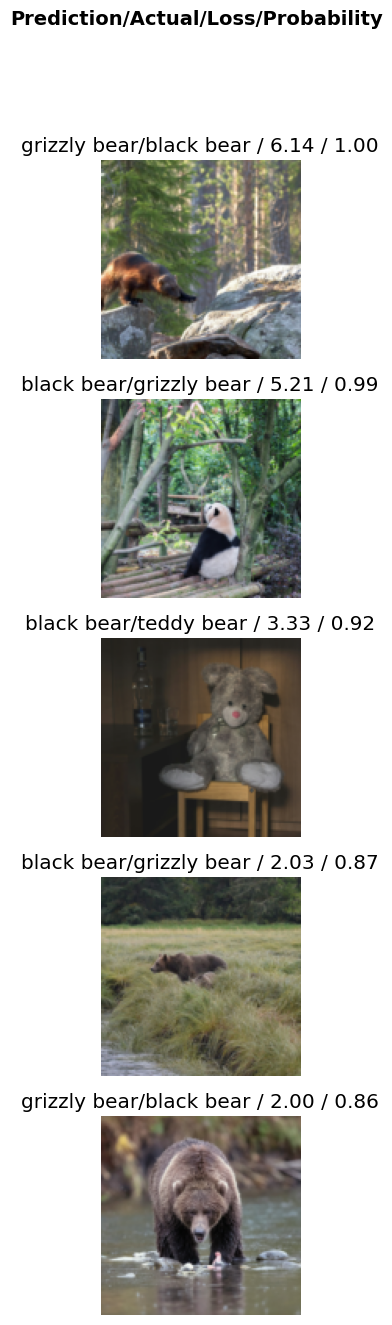

In [27]:
interp.plot_top_losses(5, nrows=5)


# Cleaning the data set

In [28]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [29]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [30]:
learn.export()

In [31]:
path = Path()
path.ls(file_exts='.pkl')


(#1) [Path('export.pkl')]

In [32]:
learn_inf = load_learner(path/'export.pkl')
learn_inf.predict('bears1/teddy bear/photo-1543886151-3bc2b944c718.jpg')

d:\programming\project\venv\Lib\site-packages\fastai\learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


('teddy bear', tensor(2), tensor([2.0222e-07, 9.9507e-07, 1.0000e+00]))

In [33]:
learn_inf.dls.vocab

['black bear', 'grizzly bear', 'teddy bear']

## Turning our notebook into an online application

In [34]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

### We turn the image into an object

In [36]:
img = PILImage.create(btn_upload.data[-1]) ## this will be the image that the user uploads

### Display image

In [37]:
out_pl = widgets.Output()
out_pl.clear_output() ## clear the output before each run
with out_pl:display(img.to_thumb(128,128))
out_pl

Output()

### Make prediction

In [39]:
pred,pred_idx,probs = learn_inf.predict(img)

### Display image with label

In [40]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly bear; Probability: 0.9694')

### Classification Button

In [44]:
btn_run = widgets.Button(description = 'Classify')  ## 
btn_run  

Button(description='Classify', style=ButtonStyle())

### Defining an onclick event

In [46]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl:display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)


### Putting everything together

In [47]:
VBox([widgets.Label('Select your bear!'),
      btn_upload, btn_run, out_pl, lbl_pred])